In [3]:
# 必要なライブラリのインポート
import matplotlib.pyplot as plt #描画ライブラリ
import pandas_datareader.data as web #データのダウンロードライブラリ
import pandas as pd
import numpy as np
import cvxopt
import os
import datetime

# ディレクトリの指定
os.chdir('C:/Users/bldyr/OneDrive/デスクトップ/自己研鑽用/データ取得')

データソースから日次データ（株価等）を取得し，週次の収益率に変換する関数  
1. data     : 取得データを選択（例：TOPIX）
2. company  : データソースを選択（例：Yahoo finance）
3. start    : データ取得開始日
4. end      : データ取得終了日

In [4]:
def get_val(data, company, start, end):
    try: 
        return ((web.DataReader(data, company, start, end)["Adj Close"].dropna()).pct_change(axis = 0)).resample(rule="W").mean() # resample で止めちゃうとエラーが出る
    except:
        pass
    return 0

日経225とS&P500のデータを取得し，週率の収益率に変換後，Excelファイルに書き出し（取得データの確認のため）

In [14]:
data = ["^N225", "2510.T"]               # Yahoo_financeの証券コード "2510.T":NOMURA BPI, "^GSPC":S&P500
company = "yahoo"                       # Yahoo Finance からデータ取得
start = datetime.datetime(1983,1,4)     # データのスタート時点
end = datetime.datetime(2022,1,14)      # データの終了時点

df = get_val(data, company, start, end)
df.to_excel('Data_weekly.xlsx', sheet_name = 'Data')

<AxesSubplot:>

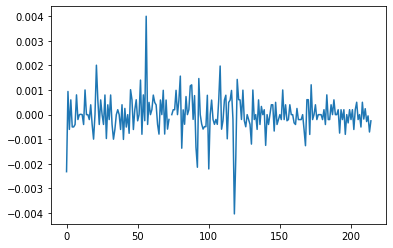

In [20]:
df.loc[:, "NOMURA BPI"].plot()

データの確認後に再度収益率（週率）を読み込みし，データの確認

In [42]:
df = pd.read_csv("data_weekly.csv", encoding="shift-jis") 
df.rename(columns = {'^N225' : "日経225", "2510.T" : "NOMURA BPI"}, inplace = True)
df["Date"] = (df["Date"].str[:4]).astype(float) # Dateのデータタイプの変更
df.head()

,Date,日経225,NOMURA BPI
0,2017.0,0.014194,-0.002318
1,2017.0,-0.002263,0.000942
2,2017.0,0.003100,-0.000599
3,2017.0,-0.001203,0.000601
4,2018.0,0.020712,-0.000500


ポートフォリオの期待収益率とボラティリティを計算．ターゲット・データ・ファンドの投資ウェイトを参考に，各時点での投資比率を変更するようにする．  
$$
stock(t) = \frac{w - (age + t)}{100}  \\
bond(t) = 1 - stock(t)
$$

$t$  :将来時点（年）  
$w$  :初期時点の株式投資比率  
$age$:現在の年齢

各時点$t$（年次）における投資ウェイトより，ポートフォリオの期待収益率$\nu(t)$とボラティリティ$\sigma(t)$を計算．
$$
w_{port}(t) = [stock(t),bond(t)] \\
\bold{E}_{port}(t) = [ \bold{E}_{stock}(t), \bold{E}_{bond}(t) ] \\ 
r_{port}(t) = <\bold{E}_{port}(t), w_{port}^{\rm{T}}(t)>_{R^2}  \\
\sigma_{port}(t) = \sqrt{w_{port}(t)V(t)w_{port}^{\rm{T}}(t)}
$$

$w_{port}(t)$ : 時点$t$における投資ウェイト  
$\bold{E}_{port}(t)$ : 時点$t$における株式・債券の期待収益率（週率）  
$r_{port}(t)$ : 時点$t$におけるポートフォリオの期待収益率  
$\sigma_{port}(t)$ : 時点$t$におけるポートフォリオのボラティリティ  
$V(t)$ : 時点$t$における分散共分散行列 

In [43]:
returns = [df["日経225"].mean(), df["NOMURA BPI"].mean()]
print(returns)

[0.0003436995934579437, 5.2979018691588615e-06]


#### 取得データより計算した期待収益率・ボラティリティ（週率）より，ポートフォリオの指標を計算

In [44]:
returns = np.append(df["日経225"].mean(), df["NOMURA BPI"].mean()).T
print(returns)

[3.43699593e-04 5.29790187e-06]


In [45]:
matrix = np.cov(df["日経225"], df["NOMURA BPI"]) 
print(matrix)

[[ 4.67389585e-05 -4.85944435e-07]
 [-4.85944435e-07  5.86130932e-07]]


In [53]:
w = 100 # 初期時点の株式投資ウェイト
age = 0 # 現在の年齢
vol = [] # ボラティリティを格納するリストを用意
rate = [] # 期待収益率を格納するリストを用意
expected_return = np.append(df["日経225"].mean(), df["NOMURA BPI"].mean())
matrix = np.cov(df["日経225"], df["NOMURA BPI"]) 

for i in range(100):
    if (w - (age + i)) >= 0:
        wgt = np.array([w - (age + i), 100 - (w - (age + i))]) / 100
    else:
        wgt =  np.array([0, 100]) / 100        
    returns = np.dot(wgt, expected_return.T) # これでやってるのは週率データ
    stev = np.sqrt(np.dot(np.dot(wgt, matrix), wgt.T))
    rate.append(returns)
    vol.append(stev)

print(rate)

[0.0003436995934579437, 0.00034031557654205585, 0.000336931559626168, 0.00033354754271028015, 0.0003301635257943923, 0.0003267795088785044, 0.00032339549196261656, 0.00032001147504672877, 0.0003166274581308409, 0.0003132434412149531, 0.00030985942429906523, 0.0003064754073831774, 0.0003030913904672895, 0.00029970737355140164, 0.0002963233566355138, 0.00029293933971962595, 0.0002895553228037381, 0.00028617130588785025, 0.0002827872889719624, 0.00027940327205607456, 0.0002760192551401867, 0.00027263523822429887, 0.000269251221308411, 0.0002658672043925232, 0.00026248318747663533, 0.0002590991705607475, 0.00025571515364485964, 0.0002523311367289718, 0.0002489471198130839, 0.0002455631028971961, 0.00024217908598130823, 0.00023879506906542038, 0.00023541105214953256, 0.00023202703523364472, 0.00022864301831775687, 0.00022525900140186902, 0.00022187498448598118, 0.0002184909675700933, 0.00021510695065420546, 0.0002117229337383176, 0.00020833891682242977, 0.00020495489990654192, 0.00020157088

In [54]:
df_1 = pd.DataFrame({"日経225" : rate,
                     "NOMURA BPI" : vol},
                     index = None)

df_1.to_excel('Portfolio_100.xlsx', sheet_name = 'Data')

#### 1年ごとに期待収益率・ボラティリティ（週率）を計算し，その結果を下にポートフォリオの指標を計算．

In [38]:
w = 100      # 初期時点の株式投資ウェイト
vol = []     # ボラティリティを格納するリストを用意
rate = []    # 期待収益率を格納するリストを用意

for i in range(100):
    if df.iat[0, 0] + i <= df["Date"].max():
        if (w - (age + i)) >= 0:
            wgt = np.array([w - (age + i), 100 - (w - (age + i))]) / 100
        else:
            wgt =  np.array([0, 100]) / 100        
        data = df[df["Date"] == df.iat[0, 0] + i]
        returns = np.dot(wgt, np.append(data["日経225"].mean(), data["NOMURA BPI"].mean()).T) # これでやってるのは週率データ
        matrix =  np.cov(data["日経225"], data["NOMURA BPI"]) # 後ほど修正が必要な個所
        stev = np.sqrt(np.dot(np.dot(wgt, matrix), wgt.T))
        rate.append(returns)
        vol.append(stev)
    else:
        break

print(vol)

[0.003933275363736435, 0.0036299161308282557, nan, 0.005812880441193124, 0.002878127520741216, 0.0010404349559562738]


In [9]:
w = 100 # 初期時点の株式投資ウェイト
age = 40 # 現在時点の年齢

rate = []
vol = [] # ボラティリティを格納するリストを用意

for i in range(100):
    if df.iat[0, 0] + i <= df["Date"].max():
        if (w - (age + i)) >= 0:
            wgt = np.array([w - (age + i), 100 - (w - (age + i))]) / 100
        else:
            wgt =  np.array([0, 100]) / 100        
        data = df[df["Date"] == df.iat[0, 0] + i]
        returns = np.dot(wgt, np.append(data["日経225"].mean(), data["S&P500"].mean()).T) # これでやってるのは週率データ
        matrix =  np.cov(data["日経225"], data["S&P500"]) # 後ほど修正が必要な個所
        stev = np.sqrt(np.dot(np.dot(wgt, matrix), wgt.T))
        rate.append(returns)
        vol.append(stev)
    else:
        break

In [10]:
df_1 = pd.DataFrame({"期待収益率" : rate,
                     "ボラティリティ" : vol},
                     index = None)

df_1.to_excel('Portfolio.xlsx', sheet_name = 'Data')